# Creating baseline performance for CanESM on SOCAT


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-10-10 12:59:50.001126: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-10-10 12:59:50.001776: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
can_data_path = "../../data/can_001"

def read_xarray_can(dir_name=""):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature mpi
    '''
    date="198201-201712"
  
    file_type ="CanESM2r1r10"
    #Chl_2D_mon_CanESM2r1r10_1x1_198201-201712.nc
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_can(can_data_path)

xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_1972613/2487652354.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")


In [3]:
xco2_df = pd.DataFrame()
xco2_df["XCO2"] = xco2.XCO2
xco2_df.index = xco2.time

data_read=xr.merge([mld.MLD,mld.MLD_socat,chl.Chl,chl.Chl_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat])


tmp_data=data_read.to_dataframe().reset_index()
tmp_data["time"] = tmp_data["time"].astype("string")
tmp_data["time"] = pd.to_datetime(tmp_data["time"], format='%Y-%m')
tmp_data["time"] = tmp_data["time"].dt.strftime("%Y-%m")

In [4]:
later_df = tmp_data
later_df = later_df.set_index(['time','ylat','xlon'])
pco2_data = pco2.pCO2.to_dataframe()
pco2_data_socat = pco2.pCO2_socat.to_dataframe()
later_df["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
later_df["pCO2"]=pco2_data["pCO2"]

In [5]:
tmp_data = xco2_df.join(tmp_data.set_index('time'),how = "right")
tmp_data.dropna(subset = ["XCO2"], inplace=True)
tmp_data = tmp_data.reset_index()

In [6]:
tmp_data.columns = ["time",'XCO2','xlon', 'ylat','MLD','MLD_socat','Chl','Chl_socat','SST','SST_socat','SSS','SSS_socat']

In [7]:
tmp_data.dropna(subset = ["Chl"], inplace=True)

In [8]:
pco2_data = pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat = pco2.pCO2_socat.to_dataframe().reset_index()

tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]
tmp_data=tmp_data.dropna(subset = ["pCO2"])

In [9]:
tmp_data.isna().sum()

time                 0
XCO2                 0
xlon                 0
ylat                 0
MLD           10316460
MLD_socat     10316460
Chl                  0
Chl_socat            0
SST           10316460
SST_socat     10316460
SSS                  0
SSS_socat            0
pCO2_socat           0
pCO2                 0
dtype: int64

In [10]:
time = tmp_data.time

In [11]:

features_socat = ['xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# features_socat = ['xlon', 'ylat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
# features = ['xlon', 'ylat','SST','SSS','Chl','XCO2','pCO2']



# create separate dataframe for socat
combined_socat=tmp_data[features_socat]
combined=tmp_data[features]

In [12]:
X_socat=combined_socat.iloc[:,:-1]
X=combined.iloc[:,:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']

In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)

regressor=RandomForestRegressor(n_estimators=20, random_state=42, verbose=3,n_jobs=-1, 
                                max_depth=10,warm_start= True)
regressor.fit(X_train, y_train)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.3s remaining:    0.0s
[P

Scores: [104.81674289 104.848233   104.51232237]
Mean: 104.72576608358561
Standard deviation: 0.15147402766395213


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.3s finished


In [15]:
y_pred=regressor.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.9s finished


104.90130022214105

In [16]:
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.3s finished


104.87193037155619

In [17]:
## Full Data - CanESM
# rmse with  :  104.87 uatm

## Socat 
# # rmse with MLD : on 34.5 uatm in tracks /full  286.7 uatm with coordinate

In [18]:
#predicted_df = pd.DataFrame(X, columns = ['xlon', 'ylat','Chl','SST','SSS','XCO2'])
predicted_df = pd.DataFrame(X, columns = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'])
predicted_df["pred"] = y_pred
predicted_df["true"] = y.to_numpy()

In [19]:
time=time.reset_index(drop=True)

In [20]:
predicted_df["time"]= time
predicted_df = predicted_df.set_index(['time','ylat','xlon'])

In [21]:
new_df = later_df
row_ind = predicted_df.index
new_df.loc[row_ind,"pred"] = predicted_df["pred"]

In [22]:
new_df["res"] = new_df["pred"] - new_df["pCO2"]

In [23]:
new_df=new_df.reset_index()

In [24]:
col_names = ["time","lon","lat","pred"]
pred_df = new_df[["time","xlon","ylat","pred"]]
pred_df.columns = col_names
pred_df['time'] = pd.to_datetime(pred_df['time'])
pred_df = pred_df.set_index(["time","lat","lon"])

col_names = ["time","lon","lat","res"]

res_df = new_df[["time","xlon","ylat","res"]]
res_df.columns = col_names
res_df['time'] = pd.to_datetime(res_df['time'])
res_df = res_df.set_index(["time","lat","lon"])


pred_xarray = pred_df.to_xarray()
res_xarray = res_df.to_xarray()

/tmp/ipykernel_1972613/85856999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['time'] = pd.to_datetime(pred_df['time'])
/tmp/ipykernel_1972613/85856999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['time'] = pd.to_datetime(res_df['time'])


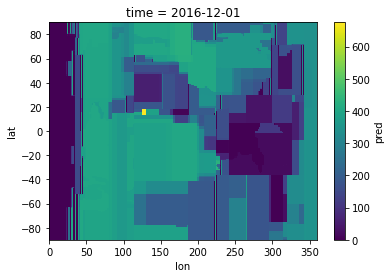

In [25]:
p1 = pred_xarray.pred[419].plot()
plt.savefig("../../assets/canESM_rf_pred.jpg")

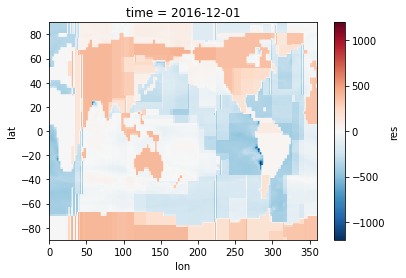

In [26]:
res_xarray.res[419].plot()
plt.savefig("../../assets/canESM_rf_res.jpg")

/tmp/ipykernel_1972613/2119154728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df['time'] = pd.to_datetime(true_df['time'])


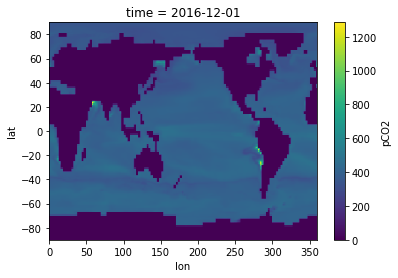

building tree 2 of 20
building tree 5 of 20
building tree 11 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 5 of 20
building tree 9 of 20
building tree 13 of 20
building tree 17 of 20
building tree 1 of 20
building tree 5 of 20
building tree 9 of 20
building tree 13 of 20
building tree 17 of 20
building tree 4 of 20
building tree 6 of 20
building tree 10 of 20
building tree 15 of 20
building tree 19 of 20
building tree 3 of 20
building tree 6 of 20
building tree 10 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 6 of 20
building tree 10 of 20
building tree 14 of 20
building tree 18 of 20
building tree 1 of 20
building tree 8 of 20
building tree 12 of 20
building tree 16 of 20
building tree 20 of 20
building tree 4 of 20
building tree 8 of 20
building tree 12 of 20
building tree 16 of 20
building tree 20 of 20
building tree 4 of 20
building tree 8 of 20
building tree 11 of 20
building tree 15 of 20
building

In [27]:
col_names = ["time","lon","lat","pCO2"]
true_df = new_df[["time","xlon","ylat","pCO2"]]
true_df.columns = col_names
true_df['time'] = pd.to_datetime(true_df['time'])
true_df = true_df.set_index(["time","lat","lon"])


true_xarray = true_df.to_xarray()

true_xarray.pCO2[419].plot()